In [1]:
%matplotlib inline
# encoding: utf-8
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import math
from glob import glob
import fileinput
import re
import collections
import pickle 
from alphabet_detector import AlphabetDetector
import os
import seaborn as sns
import community
from collections import deque
pd.set_option('display.max_rows', 10)
pd.set_option('precision', 2)

# Politistics
Political alienation is a recurring theme in todays politics, recently we witnessed it playing a role in the American election as well as the british _Brexit_. Paradoxically we are in an age where polticians can connect to the voters in many new ways, and we saw social media, like Twitter, being widely used in the recent american election.

In this report we will be analysing how politicians use social media, who they talk about, what they talk about and how they talk about them. It is difficult to say what is the cause of polticial alienation, but smear campaigns and negative rhetorics amongst polticians could be a symptom as well as a cause, other factors could be at play but will not be the focus of this project. 

We will be using graph theory to both visualize and analyse our data as well as text analysis, namely tf-idf and word sentiment to analyse the contents of tweets. Our goal is to try to shed some light on how Twitter is used on the political stage, such as who thay talk about and how they talk about each other.

## The Data
By using [tweepy](http://www.tweepy.org/) we have collected the last 3400 tweets from 518 politicians on Twitter found [here](http://www.tweepy.org/). By scraping and cross referencing names from [this](http://www.danskepolitikere.dk/) website and manually finding and entering politicial parties, we have been able to identify the party of 234 of the 514 politicians. This has enabled us to construct directed graphs, using politicians Twitter accounts as nodes and referrences to other politicians as edges in the graph. 

In [3]:
# load in word valence dict
sentimentDict = {}
fnames = glob('AFINN-*.txt')
for line in fileinput.FileInput(fnames):
    words = line.split('\t')
    word = words[0]
    sentimentDict[word] = words[1]


df1 = pd.read_csv('politiciansFull.csv')
df2 = pd.read_csv('politiciansPartiesUtf.csv')

fullDf = pd.merge(df1, df2, how='left', on=['name'])
# using the left right spectrum collected from http://www.altinget.dk/artikel/det-nye-politiske-kompas
# we have indexed every politican with a corresponding index on the left right scale 

parties = ["Enhedslisten", 'Alternativet', "Socialistisk Folkeparti", 
           "Socialdemokraterne", 'Radikale Venstre', 'Venstre', 
           'Det Konservative Folkeparti', 'Liberal Alliance', 'Dansk Folkeparti'] 

colorCoding = {'Venstre':'b', 'Socialdemokraterne': 'r', 'Radikale Venstre': 'm', 
               'Enhedslisten':'#9F000F', 'Socialistisk Folkeparti':'#C24641', 'Liberal Alliance':'#82CAFF', 
               'Dansk Folkeparti':'#FFD801', 'Det Konservative Folkeparti': '#347C17', 'Alternativet': '#00FF00'}

fullDf

name twitterAccount  followers  following  tweets  \
0      Margrethe Vestager      @vestager     172234        280    5318   
1    Lars Løkke Rasmussen    @larsloekke      80089        302     926   
2              Søren Pind     @sorenpind      48086        326    9076   
3               Ida Auken      @IdaAuken      39745       1979    8588   
4       Morten Østergaard   @oestergaard      36471        736    6008   
..                    ...            ...        ...        ...     ...   
513       Henning Tønning        @Tnning         11         10       0   
514  Holger Gorm Petersen    @gorm_hogpe         10          1       0   
515         Carsten Abild  @carstenabild         10          0       0   
516      Arne Kristiansen     @ArneBoelt          9         17       0   
517           Hans Thorup    @HansThorup          6          5       0   

     created_at              type             Party  
0    20/01-2009                EU  Radikale Venstre  
1    24/03-2009       Folketinget           Venstre  
2    25/10-2007       Folketinget           Venstre  
3    12/03-2009       Folketinget  Radikale Venstre  
4    20/01-2009       Folketinget  Radikale Venstre  
..          ...               ...               ...  
513  07/09-2012  Regionalt/lokalt               NaN  
514  04/12-2013  Regionalt/lokalt               NaN  
515  21/06-2012  Regionalt/lokalt               NaN  
516  30/11-2013  Regionalt/lokalt               NaN  
517  26/11-2013  Regionalt/lokalt               NaN  

[518 rows x 8 columns]

In [4]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

print str(get_size('cleaned_politikere_tweets')/1000000.0) + " MB"

66.590962 MB


## Analysis

### Basic Network Statistics
From the collected data we have built two different networks, one which is a directed graph and one which is a directed multi graph. The two have different advantages, the regular graph allows for more analysis to be performed by libraries such as _community_, while the multi graph is a better model for the information, since it models the refences as edges in one-to-one.

The following functions are used for generating the graphs.

In [5]:
# add politicians as nodes, depending on their party, then give them
# an index on the left-right political spectrum and and a poltical block
def loadInNodes(G):
    for index, row in fullDf.iterrows():
        if pd.isnull(row['Party']):
            G.add_node(row['twitterAccount'], 
                       {'name': row['name'], 'followers': row['followers'], 
                        'following': row['following'], 'tweets': row['tweets'], 
                        'created_at':row['created_at'], 'type': row['type'], 'party': 'None'})
        else:
            psIndex = -1
            block = -1
            if row['Party'] == 'Venstre':
                block = 1
                psIndex = 7
            elif row['Party'] == 'Socialdemokraterne':
                psIndex =  4
                block = 0
            elif row['Party'] == 'Radikale Venstre':
                psIndex = 1
                block = 0
            elif row['Party'] == 'Enhedslisten':
                psIndex = 2
                block = 0
            elif row['Party'] == 'Socialistisk Folkeparti':
                psIndex = 3
                block = 0
            elif row['Party'] == 'Liberal Alliance':
                psIndex = 6
                block = 1
            elif row['Party'] == 'Dansk Folkeparti':
                psIndex = 8
                block = 1
            elif row['Party'] == 'Det Konservative Folkeparti':
                psIndex = 5
                block = 1
            elif row['Party'] == 'Alternativet':
                psIndex = 0
                block = 0
            G.add_node(row['twitterAccount'], 
                       {'name': row['name'], 'followers': row['followers'], 
                        'following': row['following'], 'tweets': row['tweets'], 
                        'created_at':row['created_at'], 'type': row['type'], 
                        'party': row['Party'], 'politicalSpectrum': psIndex, 'Block': block})

In [6]:

# load in edges based on each reference made 
# from a poltician to another politician.
# if a reference is found the the sentiment profile of
# the tweet is also stored in the edge for later
# if the graph is not a multi graph 
# then it adds weight to edges
def loadInEdges(G):
    for index, row in fullDf.iterrows():
        foundCSV = False
        try:
            tweets = pd.read_csv('cleaned_politikere_tweets/' + 
                                 row['twitterAccount'][1:] + ".csv")
            foundCSV = True
        except:
            pass
        if foundCSV:
            for tweet in tweets['text']:
                for politician in fullDf['twitterAccount']:
                    if str(politician) in tweet:
                        sentiment = 0
                        words = tweet.replace(',','').replace('.','').split(' ')
                        count = 0
                        for word in words:
                            if word in sentimentDict:
                                sentiment += int(sentimentDict[word])
                                count += 1
                        if count != 0:
                            sentiment = sentiment/float(count)
                        else:
                            sentiment = None
                        if type(G) == nx.DiGraph:
                            if G.has_edge(row['twitterAccount'],politician):
                                if sentiment != None:
                                    if G.edge[row['twitterAccount']][politician]['sentiment'] != None:
                                        G.edge[row['twitterAccount']][politician]['sentiment'] += int(sentiment)
                                    else:
                                        G.edge[row['twitterAccount']][politician]['sentiment'] = int(sentiment)
                                G.edge[row['twitterAccount']][politician]['weight'] += 1
                            else:
                                G.add_edge(row['twitterAccount'], politician, sentiment=sentiment, weight=1)
                        elif type(G) == nx.MultiDiGraph:
                            G.add_edge(row['twitterAccount'], politician, sentiment=sentiment)
    # remove all nodes that are not connected to any other poltician
    G.remove_nodes_from(nx.isolates(G))

In [7]:
# draw the given graph, amount of followers dictates size
# of node and party determines color
def drawPoliGraph(G, alpha):
    plt.figure(1, figsize=(15,15))
    pos=nx.spring_layout(G, k=0.9)
    for node in G.nodes():
        color = 'w'
        if G.node[node]['party'] in colorCoding:
            color = colorCoding[G.node[node]['party']]
        else:
            color = '#999966'
            
        nx.draw_networkx_nodes(G,pos,
                           nodelist=[node],
                           node_color=color,
                           node_size=G.node[node]['followers']/80 + 5,alpha=0.8)
        if G.node[node]['followers']>20000:
            nx.draw_networkx_labels(G, pos, font_size= 8,font_color='w',labels= {node.decode("utf-8"):G.node[node]['name'].decode("utf-8")})
    nx.draw_networkx_edges(G, pos, arrows=False, width=0.3, alpha=alpha)
    

Lets generate and plot the two different graphs.

In [8]:
G = nx.DiGraph()
loadInNodes(G)
loadInEdges(G)

In [9]:
multiG = nx.MultiDiGraph()
loadInNodes(multiG)
loadInEdges(multiG)

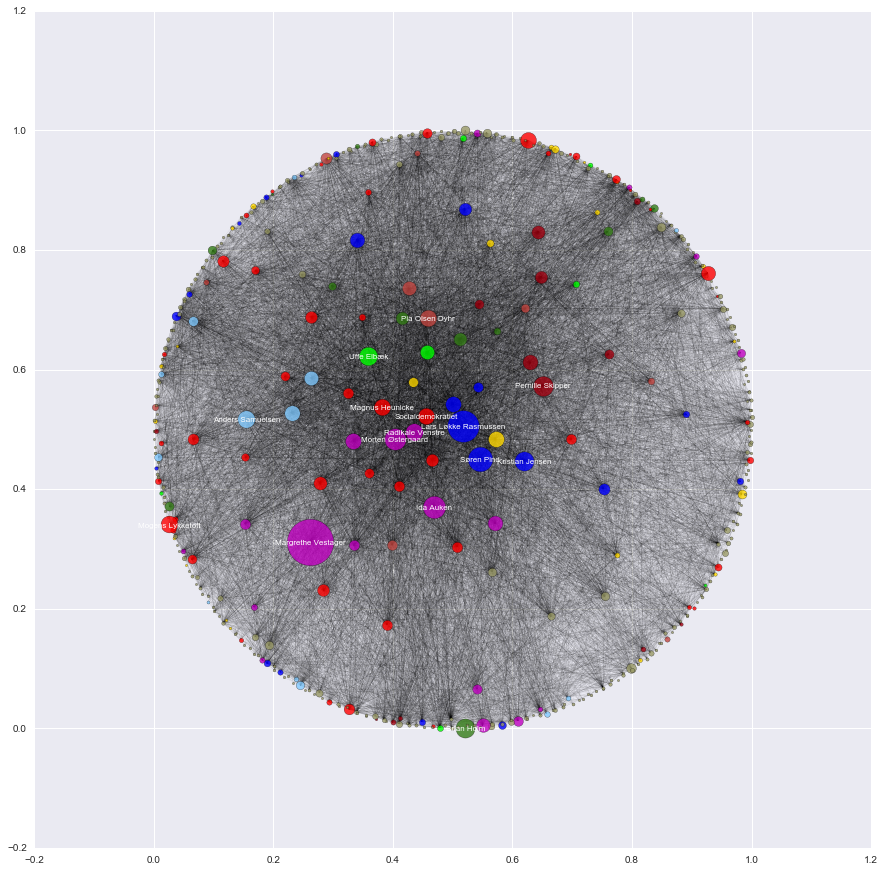

In [10]:
drawPoliGraph(G, 0.1)

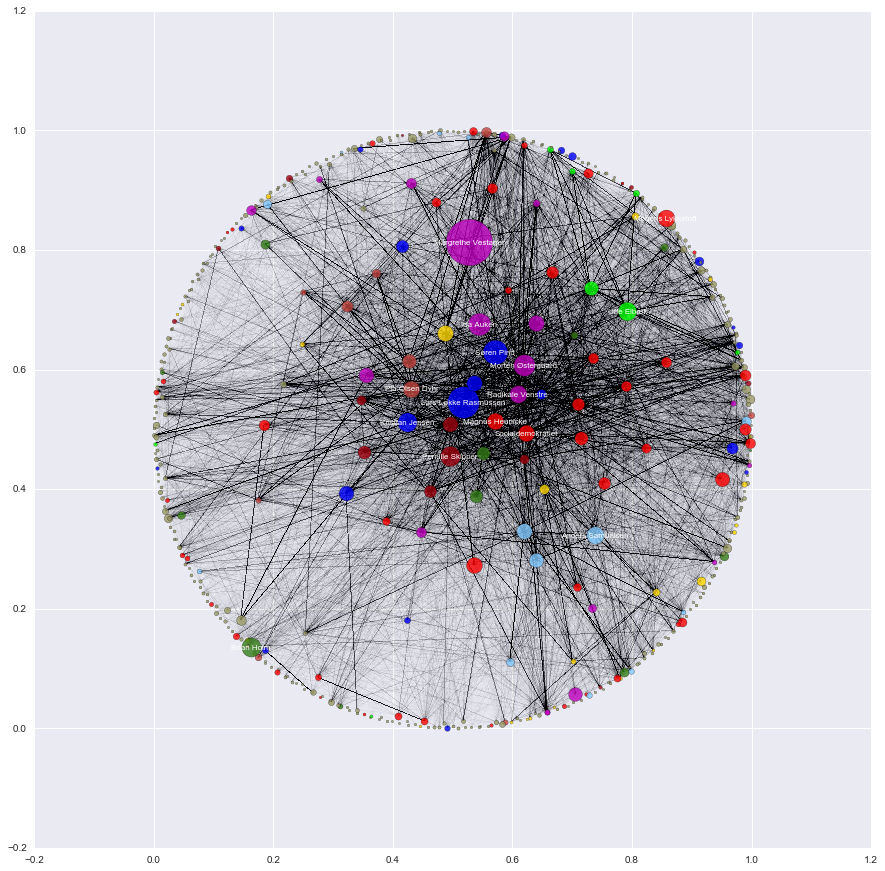

In [11]:
drawPoliGraph(multiG,0.01)

Both graphs contains 455 nodes but the directed graph only contains 18484 edges whereas the multi graph contains 158845.

In [12]:
print "Directed Graph Edges: " + str(len(G.edges()))
print "Directed Multi Graph Edges: " + str(len(multiG.edges()))

print "Directed Graph Nodes:" + str(len(G.nodes()))
print "Directed Multi Graph Nodes:" + str(len(multiG.nodes()))

Directed Graph Edges: 18484
Directed Multi Graph Edges: 158845
Directed Graph Nodes:455
Directed Multi Graph Nodes:455


By having a look at the degree distribution of the multigraph, we can see like most social networks it follows the degree distribution of a scale free network.

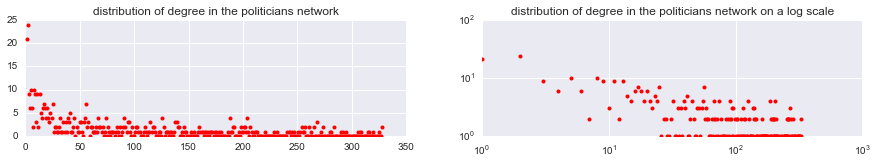

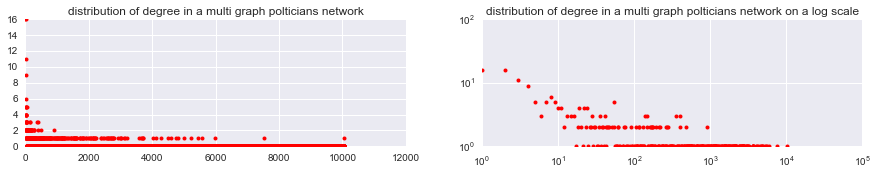

In [13]:
GDegrees = G.degree(G.nodes()).values()
Dmax = np.amax(GDegrees)
Dmin = np.amin(GDegrees)
hist, bins = np.histogram(GDegrees, range(Dmin, (Dmax + 1)))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.subplots_adjust(hspace=0.4)
plt.subplots(figsize=(15,5))
plt.subplot(221)
plt.plot(center, hist, 'ro', markersize=4)
plt.title('distribution of degree in the politicians network')

plt.subplot(222)
plt.loglog(center, hist, 'ro', markersize=4)
plt.title('distribution of degree in the politicians network on a log scale')

GDegrees = multiG.degree(multiG.nodes()).values()
Dmax = np.amax(GDegrees)
Dmin = np.amin(GDegrees)
hist, bins = np.histogram(GDegrees, range(Dmin,(Dmax + 1)))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.subplots_adjust(hspace=0.4)
plt.subplots(figsize=(15,5))
plt.subplot(223)
plt.plot(center, hist, 'ro', markersize=4)
plt.title('distribution of degree in a multi graph polticians network')

plt.subplot(224)
plt.loglog(center, hist, 'ro', markersize=4)
plt.title('distribution of degree in a multi graph polticians network on a log scale')
plt.show()

Especially the directed multi graph seems to follow a power law destribution. 

## What are they talking about?
In this section we will be covering what the politicians are talking about on twitter. First we will be describing what measures have been taken to clean and prepare the data, as well as which methods we have been using to analyse differences in word patterns between parties.
### Preparing the Text Data 
Some of our preliminary attempts at plotting the word clouds resultet in some strange plots. Like the following word cloud plot of the tf-idf from the top 400 words used by _Dansk Folkeparti_.
![title](Pictures/gamingPolitiker.png)
By searching through the tweets of members of _Dansk Folkeparti_, we found out that one of the members of the parti had connected her twitter account to her player account in an ipad game. The game was then auto tweeting her accomplishments in the game, this was going on for some weeks, resulting in an abundance of words like _game_, _tribez_, _coins_, etc.
A similar case was in the following word cloud plot.
![title](Pictures/runningPolitiker.png)
Where a poltician had connected her endomondo runner application to her twitter profile, causing the words _running_, _here:_ and _km_ to show up.
Our solution to this problem was to create a cleaner function (Appendix D) that through a key identifier, like, '#Endomondo' or 'tribez' finds lines in csv files and deletes them.

Word counts and sentiment profiles are calculated using a [MRJob](https://pythonhosted.org/mrjob/) script. These scripts ([appendix A](#Appendix-A) and [Appendix E]((#Appendix-E)) use a mapreduce technique to perform operations which makes them very quick, but they are not well suited for csv files. Therefore we had to implement a cleaner.sh file [appendix C](#Appendix-C) which removed new lines within rows of the csv file. This pattern recognition as well as most others in the project is done using regular expressions.

The resulting word count dictionaries of all the politicians of each party are dumped as pickle files.
The following functions are used for retreiving the word counts, calculating the _term frequency-inverse document frequency_ (tf-idf) and plotting them in a word cloud.

In [17]:
# load in pickle word count dictionary for each party
# seperate words into hastags, references and regular words.
def loadInSepOcc(BoWsDict, RefsDict, hashtagsDict, path, minOcc = 0):
    for party in parties:
        refDict = collections.OrderedDict()
        hashDict = collections.OrderedDict()
        wordDict = collections.OrderedDict()
        BoW = pickle.load( open(path + "/" + party +  "WordCount.p", "rb" ) )
        for k,v in BoW.items():
            if v >= minOcc:
                if len(k) > 0:
                    if k[0]=='#':
                        hashDict[k] = v
                    elif k[0]=='@':
                        refDict[k] = v
                    else:
                        wordDict[k] = v
        BoWsDict[party] = wordDict
        RefsDict[party] = refDict
        hashtagsDict[party] = hashDict
        print "done " + party +" and length of bow was " + str(len(wordDict))

In [18]:
def calcTfIdf(BoW, BoWList, topAmount =  0):
    if topAmount==0:
        topAmount = len(BoW)
    tfIdfDict = {}
    # calculate total amount of words in order to calculate the frequncy
    total = float(sum(BoW.values()))
    # filter of all but a top amount of words
    words = list(BoW)[:topAmount]
    Dictionaries = []
    # build a dictionary of the needed words for fast lookup
    for D in BoWList.values():
        if topAmount != len(BoW):
            Dictionaries.append(dict((k, D[k]) for k in list(D)[:topAmount]))
        else:
            Dictionaries.append(BoW)
    # calculate the tf-idf for the top n most used words in the bag of words
    for word in words:
        n = sum(1 for x in Dictionaries if word in x)
        tf =  BoW[word] / total
        idf = math.log((len(BoWList) + 1) / float(1 + n))
        tfIdfDict[word] = tf * idf
    return tfIdfDict

In [19]:
def convertToLoT(dictionary):
    # convert to list of tuples for plotting
    LoT = []
    for word, value in dictionary.items():
        if not word.lower() in stopWords.union(STOPWORDS):
            LoT.append((word.decode('utf-8'), value))
    return LoT

In [20]:
import random
from scipy.misc import imread
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, 100%%, 50%%)" % random.randint(0, 270)

def plotWordCloud(TuplelistWord, TuplelistRef, TuplelistTag, party):
    # plot a wordcloud of the BoW
    f, axarr = plt.subplots(1, 3, figsize=(15,30))
    cloudMask = imread("Pictures/cloudMask.png")
    birdMask = imread("Pictures/twitter_mask.png")
    cloudMask2 = imread("Pictures/mask-cloud.png")
    splatMask = imread("Pictures/spot-splatter-stencil.jpg")
    wcWords = WordCloud(background_color="white", max_words=40, mask=cloudMask2)
    wcWords.generate_from_frequencies(TuplelistWord)
    axarr[0].imshow(wcWords.recolor(color_func=color_func, random_state=3))
    axarr[0].axis("off")
    
    wcRefs = WordCloud(background_color="white", max_words=40, mask=cloudMask2)
    wcRefs.generate_from_frequencies(TuplelistRef)
    axarr[1].imshow(wcRefs.recolor(color_func=color_func, random_state=3))
    axarr[1].axis("off")
    axarr[1].set_title(party, fontsize=20, fontweight='bold')
    
    wcTags = WordCloud(background_color="white", max_words=40, mask=cloudMask2)
    wcTags.generate_from_frequencies(TuplelistTag)
    axarr[2].imshow(wcTags.recolor(color_func=color_func, random_state=3))
    axarr[2].axis("off")
  

In [21]:
BoWsDict = {}
BoRDict = {}
BoHDict = {}
# import the bag of words from each party
import time
start_time = time.time()
loadInSepOcc(BoWsDict, BoRDict, BoHDict, "politiciansWordCount/")
print("--- %s seconds ---" % (time.time() - start_time))

done Enhedslisten and length of bow was 35307
done Alternativet and length of bow was 28714
done Socialistisk Folkeparti and length of bow was 35737
done Socialdemokraterne and length of bow was 91736
done Radikale Venstre and length of bow was 61592
done Venstre and length of bow was 41074
done Det Konservative Folkeparti and length of bow was 24946
done Liberal Alliance and length of bow was 25292
done Dansk Folkeparti and length of bow was 32204
--- 7.7515411377 seconds ---


In [22]:
# stop words in both dansih and english
stopWords = ("mr,na,er,om,rt,i,af,alle,andet,andre,at,begge,da,de," + 
            "den,denne,der,deres,det,dette,dig,din,dog,du,ej,eller, " +
            "en,end,ene,eneste,enhver,et,fem,fire,flere,fleste,for,fordi,"+
            "forrige,fra,få,før,god,han,hans,har,hendes,her,hun,hvad,hvem,"+
            "hver,hvilken,hvis,hvor,hvordan,hvorfor,hvornår,i,ikke,ind,ingen"+
            ",intet,jeg,jeres,kan,kom,kommer,lav,lidt,lille,man,mand,mange,med"+
            ",meget,men,mens,mere,mig,ned,ni,nogen,noget,ny,nyt,nær,næste,"+
            "næsten,og,op,otte,over,på,se,seks,ses,som,stor,store,syv,ti,til,"+
            "to,tre,ud,var").split(',')
stopWords = set(stopWords)
from wordcloud import WordCloud, STOPWORDS

Another issue that we encountered was utf encoded words that could not be displayed by the word cloud module. This was the case with words which contained non latin charachters, so we removed them when creating the word counts by using the alphabet-detector library. But some charachters stil poses problem when trying to plot them and are stil a part of the text data. These include the following.

In [23]:
array = [
    sorted(convertToLoT(calcTfIdf(BoWsDict['Socialdemokraterne'], BoWsDict, 400)), key=lambda x: x[1], reverse=True)[1][0],
    sorted(convertToLoT(calcTfIdf(BoWsDict['Socialdemokraterne'], BoWsDict, 400)), key=lambda x: x[1], reverse=True)[14][0],
    sorted(convertToLoT(calcTfIdf(BoWsDict['Socialistisk Folkeparti'], BoWsDict, 400)), key=lambda x: x[1], reverse=True)[3][0],
    sorted(convertToLoT(calcTfIdf(BoWsDict['Socialistisk Folkeparti'], BoWsDict, 400)), key=lambda x: x[1], reverse=True)[7][0],
    sorted(convertToLoT(calcTfIdf(BoWsDict['Socialistisk Folkeparti'], BoWsDict, 400)), key=lambda x: x[1], reverse=True)[7][0],
    sorted(convertToLoT(calcTfIdf(BoWsDict['Liberal Alliance'], BoWsDict, 400)), key=lambda x: x[1], reverse=True)[16][0]
]
print " ".join(array)

😎 👍 😉 😊 😊 😂


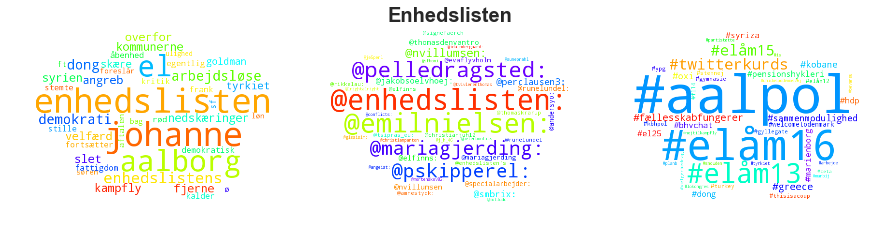

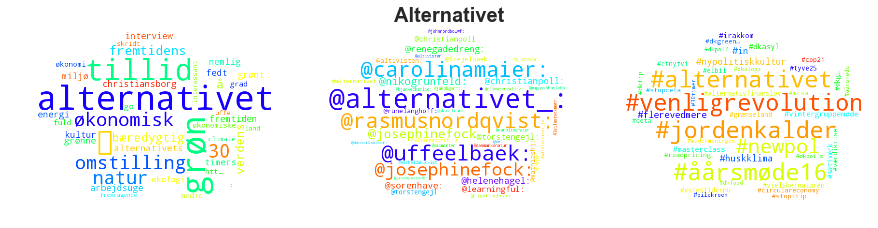

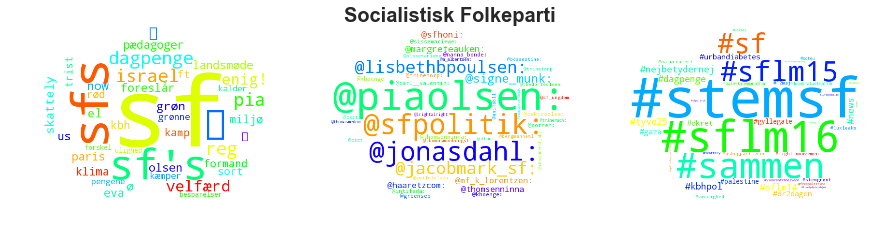

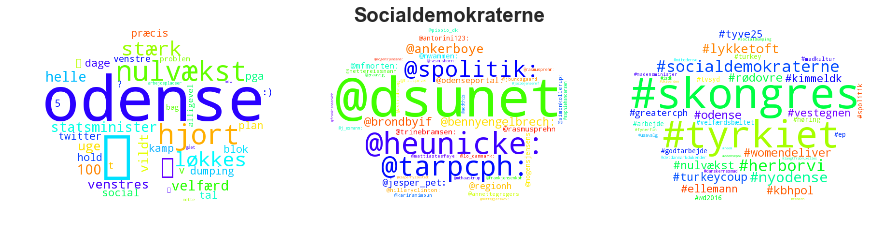

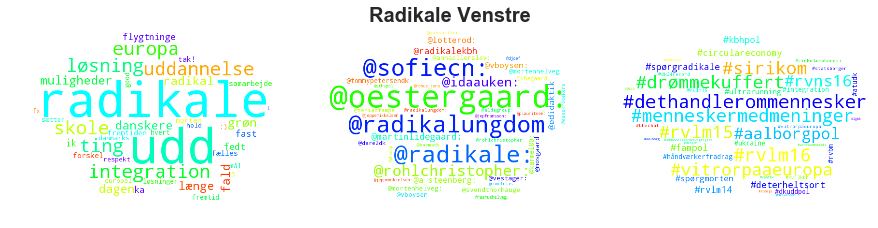

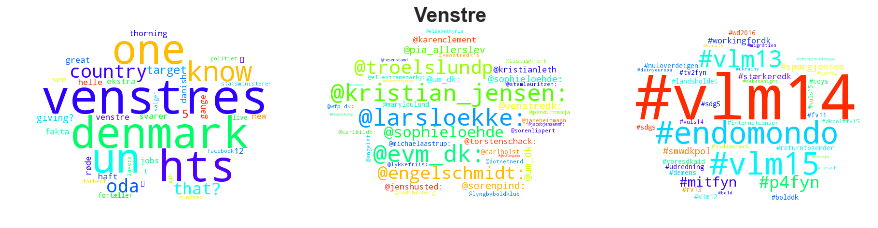

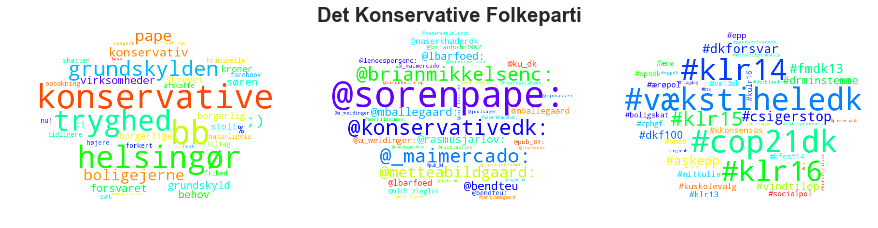

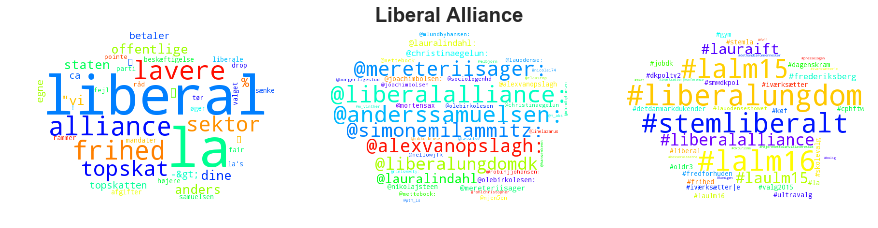

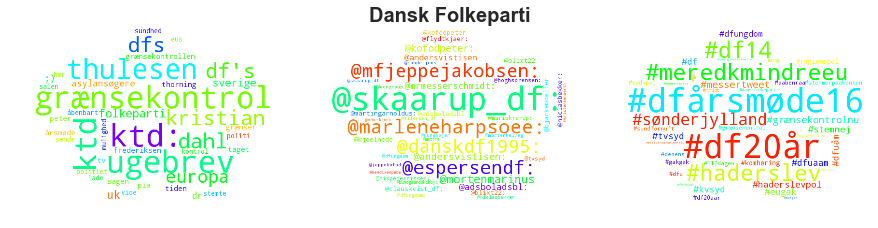

In [24]:
# plot the tf-idf of the top 400 words from each party
for party in parties:
    plotWordCloud(convertToLoT(calcTfIdf(BoWsDict[party], BoWsDict, 400)), 
                  convertToLoT(calcTfIdf(BoRDict[party], BoRDict, 400)),
                  convertToLoT(calcTfIdf(BoHDict[party], BoHDict, 400)),
                  party)

As we can see then many of the words that are scored the highest by the tf-idf algorithm are either words that are descriptive of the politicial focus areas for the given party. Such as border control (in danish _grænsekontrol_) for the right wing, nationalist conservative parti Dansk Folkeparti or green (in dansih _grøn_) for the left wing Alternativet, probably refering to green energy.

But what is also interesting is that parties tend to refer much to themselves, their party members, and events tied to their party, more than they refer to other parties, party members or events.
We will be covering this in further detail in the following section.

## Who are they talking about?
In this section we will using graph tools and theory to analyze who politicians generally talk about.

The following are the top 5 politicians that are the most central in the network are, with regards to how much they are referred to, how much they refer to others and how much they link different communities together.

In [25]:
inCentral = nx.in_degree_centrality(G)
# find the politician with highest in degree centrality
print "Top 5 Most refered to: " , sorted(inCentral, key=lambda i: inCentral[i], reverse=True)[:5]

outCentral = nx.out_degree_centrality(G)
# find the politician with highest out degree centrality
print "Top 5 Most referring: " ,sorted(outCentral, key=lambda i: outCentral[i], reverse=True)[:5]

between = nx.betweenness_centrality(multiG)
# find the politician with highest betweeness centrality
print "Top 5 Most linking: " ,sorted(between, key=lambda i: between[i], reverse=True)[:5]

Top 5 Most refered to:  ['@larsloekke', '@Spolitik', '@venstredk', '@Kristian_Jensen', '@sorenpind']
Top 5 Most referring:  ['@DanielPrehn1', '@Heunicke', '@mfMorten', '@Astridkrag', '@rasmushorn']
Top 5 Most linking:  ['@Heunicke', '@venstredk', '@oestergaard', '@Kristian_Jensen', '@mfMorten']


### Assortativity
By calculating the assortativity in relation to degree on the multi graph, we can see that polticians that are often refered to, tend to refer to each other, while politicians that are not often referred to tend to refer to each other.
This is not surprising news, as social networks tend to have these attributes.

In [26]:
assortativity = nx.degree_pearson_correlation_coefficient(multiG)
print assortativity

0.226938536205


What is more interesting is to calculate the assortativity according to their index on the political left to right spectrum. We have indexed all party members according to their party's place in the order of left to right, found on [this](http://www.altinget.dk/artikel/det-nye-politiske-kompas) website. The scale has been developed by Kenneth Thue Nielsen and are based on numbers from the research agency [Norstat](http://www.norstat.dk/)

In [27]:
assortativity = nx.attribute_assortativity_coefficient(multiG, 'politicalSpectrum')
print assortativity

0.387995119438


Indicating that politicians tend to reference other politicians that are within the same political spectrum as themselves. 

If we calculate the assortativity according to which political block they are part of, we can see that the assortivity is also quite high but lower than that of the polticial spectrum.

By _block_ we refer to whether a party is said to belong to the red or blue block, depending on if they tend to vote for the left wing or the right wing.

In [28]:
assortativity = nx.attribute_assortativity_coefficient(multiG, 'Block')
print assortativity

0.286755078824


### Modularity
By calculating the modularity, we can see whether the parties are good distributions of communities according to who they reference. This however, cannot be performed on multi graphs or directed graphs. To accomodate that the simple directed graph aggregates references, we have fitted the edges with weights to indicate that a reference has occured several times.

In [29]:
# convert to undirected
Gun = G.to_undirected()
# get the parties of the polticians
politiciansPartyDict = nx.get_node_attributes(Gun, "party")
# calculate the best partition of the parties
partitions = community.best_partition(Gun, weight='weight')

In [30]:
print community.modularity(politiciansPartyDict, Gun, weight='weight')
print community.modularity(partitions, Gun, weight='weight')
print len(set(partitions.values()))

0.352267884434
0.492532714819
20


Showing that the distribution of communities based on parties, does not defer that much from the optimal destribution, which would be to seperate the parties into 20 different parties. If we try to calculate the optimal destribution while keeping the original amount of parties we get.

In [31]:
partitions = community.best_partition(Gun, weight='weight', partition=politiciansPartyDict)
print community.modularity(partitions, Gun, weight='weight')

0.481406887762


We can than make a confusion matrix filled with percentages to visualize what percentages of which parties should be redistributed into new parties to construct the optimal destribution.

In [32]:
prctMatrix = []
for c in set(partitions.values()):
    counts = []
    for party in parties:
        count = 0
        nodesInParty = [node for node,attr in politiciansPartyDict.items() if attr == party ]
        nodesInPartition = [node for node,attr in partitions.items() if attr == c ]
        for node in nodesInPartition:
            if node in nodesInParty:
                count += 1
        counts.append(float(count)/len(nodesInParty) * 100)
        
    prctMatrix.append(counts)

columnNames = parties
Dprct = pd.DataFrame(prctMatrix, columns= columnNames)
Dprct

Enhedslisten  Alternativet  Socialistisk Folkeparti  Socialdemokraterne  \
0           0.0           0.0                      0.0               81.63   
1           0.0           0.0                      0.0                4.08   
2           0.0           0.0                     90.0                0.00   
3           0.0           0.0                      0.0                2.04   
4           0.0           0.0                      0.0                8.16   
5         100.0           0.0                     10.0                0.00   
6           0.0         100.0                      0.0                0.00   
7           0.0           0.0                      0.0                0.00   
8           0.0           0.0                      0.0                0.00   
9           0.0           0.0                      0.0                4.08   

   Radikale Venstre  Venstre  Det Konservative Folkeparti  Liberal Alliance  \
0              0.00    28.57                         0.00               0.0   
1             84.21     0.00                         0.00               0.0   
2              0.00     4.76                         0.00               0.0   
3              0.00    42.86                         0.00               0.0   
4              5.26     9.52                         0.00               0.0   
5              5.26     4.76                         0.00               0.0   
6              0.00     0.00                         0.00               0.0   
7              0.00     0.00                        91.67               0.0   
8              0.00     0.00                         0.00             100.0   
9              5.26     9.52                         8.33               0.0   

   Dansk Folkeparti  
0              0.00  
1              4.17  
2              8.33  
3              0.00  
4             83.33  
5              0.00  
6              0.00  
7              0.00  
8              4.17  
9              0.00

This table is ofcourse solely based on who politicians of each party tend to reference, and therefore sais nothing about what parties should be formed based on political views. It does however tell us that politicians tend to refer to polticians whithin their own party more than they refer to politicians that are part of other parties. This seems quite positive, and in the following section we will be covering how tend to tweet in general and about eachother.


## What is their mood?
In this section we will explore the sentiment valence of words written by politicians on Twitter. 
We will look into what it looks like over time as well as what it looks like when the politicians reference each other in a tweet.

We have used [MRJob](https://github.com/Yelp/mrjob) written by Yelp, which is a MapReduce library for Python to calculate the sentiment of a tweet and aggregate it on party by party basis. The code for our MapReduce job can be found in [Appendix E](#Appendix-E).

Here we import the files and you can see that there are many _NaN_ values which is because of how we join the files together into a DataFrame. There are fewer and fewer _NaN_ values over time when the politicians of the parties become more active

In [33]:
sentiDf = pd.DataFrame()
for party in parties:
    senti = pd.read_csv('partier/sentiment_'+party+'.tsv', 
                         sep='\t',
                         parse_dates=[0],
                         header=None, 
                         names = ["Date", party],
                         index_col=0
                        )
    sentiDf = sentiDf.join(senti, how='outer')
sentiDf

Enhedslisten  Alternativet  Socialistisk Folkeparti  \
Date                                                              
2009-03-11           NaN           NaN                      NaN   
2009-03-12           NaN           NaN                      NaN   
2009-03-13           NaN           NaN                      NaN   
2009-03-14           NaN           NaN                      NaN   
2009-03-16           NaN           NaN                      NaN   
...                  ...           ...                      ...   
2016-10-29          0.69          0.62                     0.86   
2016-10-30          0.21          0.37                     1.31   
2016-10-31         -0.65          0.85                     0.86   
2016-11-01         -0.60          1.36                     0.09   
2016-11-02         -0.18          1.04                     1.00   

            Socialdemokraterne  Radikale Venstre  Venstre  \
Date                                                        
2009-03-11                0.67               NaN      NaN   
2009-03-12               -0.75               NaN      NaN   
2009-03-13                3.00               NaN      NaN   
2009-03-14               -3.00               NaN      NaN   
2009-03-16                2.20               NaN      NaN   
...                        ...               ...      ...   
2016-10-29                0.26              1.62     2.42   
2016-10-30                0.91              0.78     0.90   
2016-10-31                0.20              0.92     0.70   
2016-11-01                0.35              0.79     0.37   
2016-11-02                0.59              0.40     0.77   

            Det Konservative Folkeparti  Liberal Alliance  Dansk Folkeparti  
Date                                                                         
2009-03-11                          NaN               NaN               NaN  
2009-03-12                          NaN               NaN               NaN  
2009-03-13                          NaN               NaN               NaN  
2009-03-14                          NaN               NaN               NaN  
2009-03-16                          NaN               NaN               NaN  
...                                 ...               ...               ...  
2016-10-29                        -0.45              1.89              0.00  
2016-10-30                         0.83              1.00              0.14  
2016-10-31                        -1.04              0.55              0.80  
2016-11-01                         0.23              1.62              0.62  
2016-11-02                         0.42              1.60              0.50  

[2471 rows x 9 columns]

In the below plot you can see the number of _NaN_ values over time just to get a feeling with how active the different parties are on Twitter. The y-axis corresponds to how many _NaN_ values there are per row.

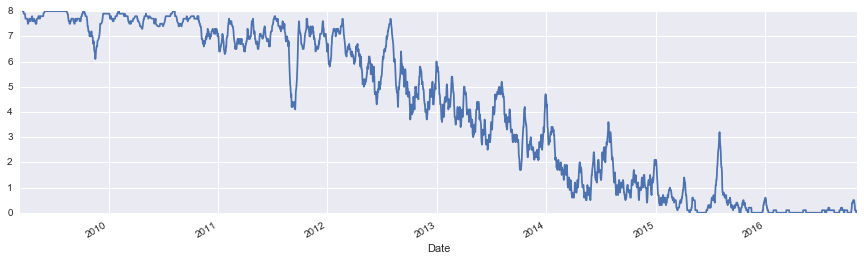

In [34]:
sentiDf.isnull().sum(axis=1).rolling(window=10).mean().plot(figsize=(15,4))

It looks like halfway through 2014 might be a good date to perform the rest of the analysis on as the activity is picking up there

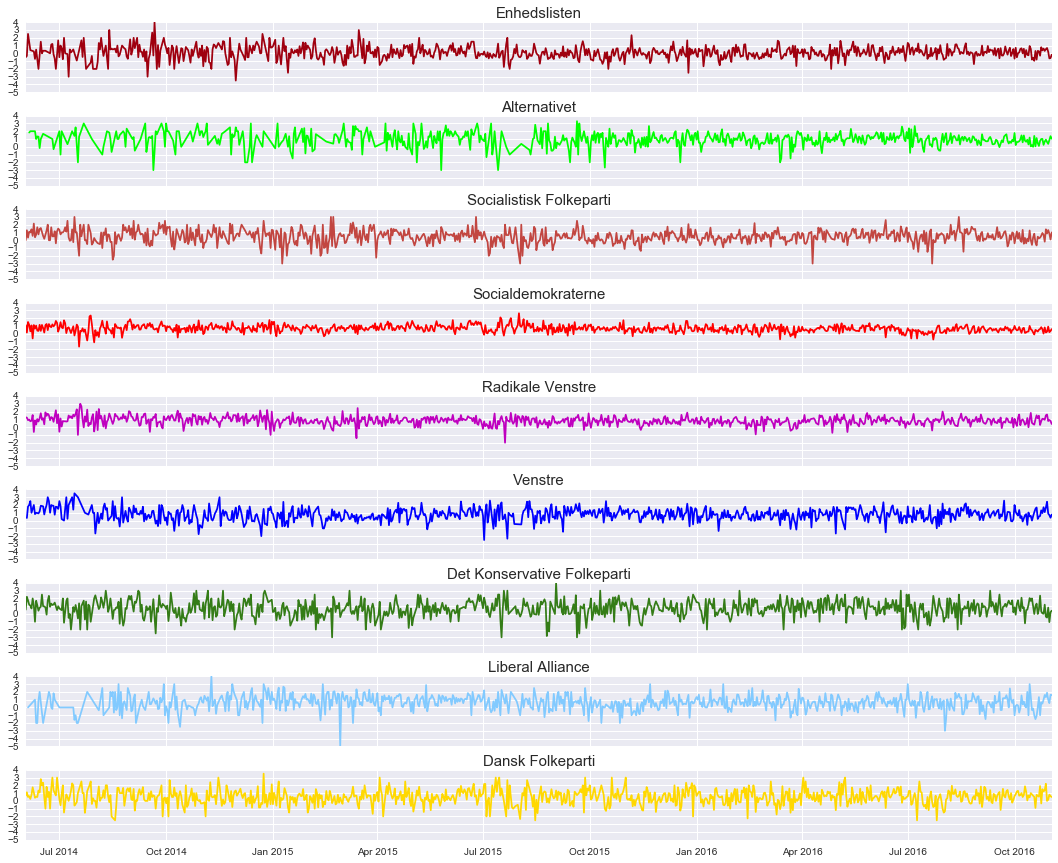

In [36]:
f, axarr = plt.subplots(9, sharex=True, sharey=True, figsize=(15,12))
count = 0
plt.tight_layout(h_pad=1.2)
for party in parties:
    axarr[count].set_title(party, fontsize = 15)
    axarr[count].plot(sentiDf['2014-06-01' < sentiDf.index][party].dropna(), c = colorCoding[party])
    count += 1
    
plt.show()

We can clearly see that most party's politicians have become more and more active on Twitter during the last years. Some parties did not have active people on Twitter before 2012.
Some had breaks for a long time and the data is generally really sparse before 2013-2014. Which is why we will focus on tweets from 2014 and onwards.

It is hard to see what is going on in the plots because of all the noise. Let's take a look at it again where we average over a period. We tried averaging over many intervals but we will only show it for the last 7 days to see if we can see a difference.

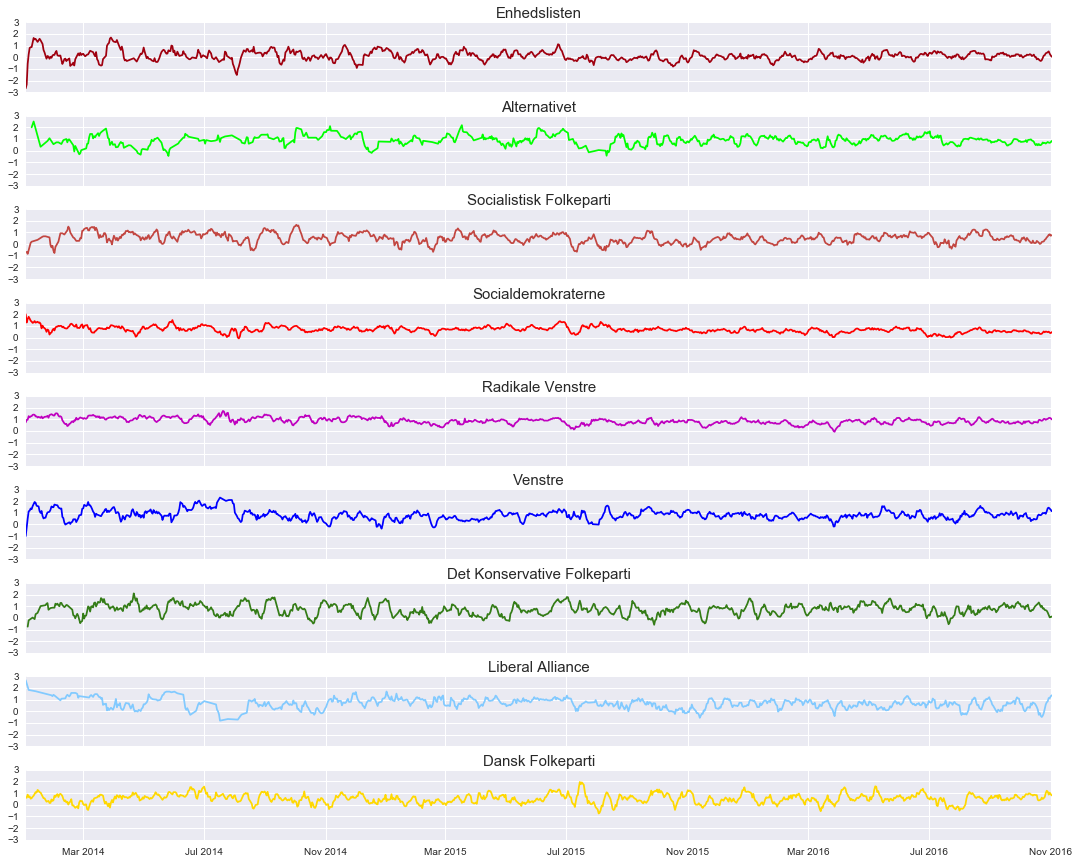

In [37]:
f, axarr = plt.subplots(9, sharex=True, sharey=True, figsize=(15,12))
count = 0
plt.tight_layout(h_pad=1.2)
for party in parties:
    axarr[count].set_title(party, fontsize = 15)
    axarr[count].plot(sentiDf['2014-01-01' < sentiDf.index][party].dropna().rolling(window=7, min_periods=0).mean(), c = colorCoding[party])
    count += 1
    
plt.show()

It is now much easier to see what is happening but we only see it on a 7 day period though. Some patterns we can notice are: all the parties are clearly more positive than they are negative, we can see they hover around 0,6 in average (we calculated it to be 0,633); and there are some tendencies that can be spotted for example a period in July where all the parties seem to have a more positive sentiment value. Some parties look like they might have a high correlation so let's look into that

Calculating the correlation between the sentiment of the parties during a **moving window average** of _7 days_ didn't give us much insight as all the values were close to 0. The two highest values were:
* _Venstre_ and _Dansk Folkeparti_ = 0,28
* _Enhedslisten_ and _Socialistisk Folkeparti_ = 0,26

If we average over the last _30 days_ we see more interesting correlations.
_Venstre_ and _Dansk Folkeparti_ is now at 0,48, and _Det Konservative Folkeparti_ and _Liberal Alliance_ are those that have the highest negative value of -0,325120.


In [38]:
sentiDf[sentiDf.index > '2014-01-01'].rolling(window=30, min_periods=0).mean().corr()

Enhedslisten  Alternativet  \
Enhedslisten                         1.00      1.62e-01   
Alternativet                         0.16      1.00e+00   
Socialistisk Folkeparti              0.24      1.60e-01   
Socialdemokraterne                   0.24      5.94e-02   
Radikale Venstre                     0.40      9.07e-02   
Venstre                              0.24      4.12e-02   
Det Konservative Folkeparti          0.12     -1.45e-01   
Liberal Alliance                     0.26     -5.12e-03   
Dansk Folkeparti                     0.12      9.63e-02   

                             Socialistisk Folkeparti  Socialdemokraterne  \
Enhedslisten                                    0.24                0.24   
Alternativet                                    0.16                0.06   
Socialistisk Folkeparti                         1.00                0.13   
Socialdemokraterne                              0.13                1.00   
Radikale Venstre                                0.43                0.51   
Venstre                                         0.28                0.23   
Det Konservative Folkeparti                     0.28                0.03   
Liberal Alliance                               -0.02                0.58   
Dansk Folkeparti                                0.26                0.29   

                             Radikale Venstre  Venstre  \
Enhedslisten                             0.40     0.24   
Alternativet                             0.09     0.04   
Socialistisk Folkeparti                  0.43     0.28   
Socialdemokraterne                       0.51     0.23   
Radikale Venstre                         1.00     0.47   
Venstre                                  0.47     1.00   
Det Konservative Folkeparti              0.18     0.22   
Liberal Alliance                         0.20    -0.21   
Dansk Folkeparti                         0.30     0.52   

                             Det Konservative Folkeparti  Liberal Alliance  \
Enhedslisten                                        0.12          2.58e-01   
Alternativet                                       -0.15         -5.12e-03   
Socialistisk Folkeparti                             0.28         -1.95e-02   
Socialdemokraterne                                  0.03          5.79e-01   
Radikale Venstre                                    0.18          1.99e-01   
Venstre                                             0.22         -2.15e-01   
Det Konservative Folkeparti                         1.00         -1.15e-01   
Liberal Alliance                                   -0.12          1.00e+00   
Dansk Folkeparti                                    0.44         -2.18e-02   

                             Dansk Folkeparti  
Enhedslisten                             0.12  
Alternativet                             0.10  
Socialistisk Folkeparti                  0.26  
Socialdemokraterne                       0.29  
Radikale Venstre                         0.30  
Venstre                                  0.52  
Det Konservative Folkeparti              0.44  
Liberal Alliance                        -0.02  
Dansk Folkeparti                         1.00

Looking at specific dates which might be important to politicians
* 2015-02-14 - A shooting happened at _Krudttønden_ in Denmark.
* 2015-04-16 - The queen turned 75 years old.
* 2015-09-02 - The first dane (Andreas Mogensen) in space
* 2016-08-15 - Danish swimmer wins gold at OL

In [39]:
print "Queen", sentiDf['2015-04-16' == sentiDf.index].mean().mean() # queen
print "Shooting", sentiDf['2015-02-14' == sentiDf.index].mean().mean() # krudttønden
print "Space", sentiDf['2015-09-02' == sentiDf.index].mean().mean() # dane in space
print "Gold OL", sentiDf['2016-08-15' == sentiDf.index].mean().mean() # Swimmer wins gold

Queen 1.15001135696
Shooting -0.520485223075
Space 0.944843908079
Gold OL 0.792612205767


One last date which should be polarizing for the parties according to their politics is:
* 2015-12-03 - No to discarding the European Union legal reservations (EU retsforbehold)

Where we some parties are very happy and others are not

In [40]:
print sentiDf['2015-12-03' == sentiDf.index].mean()

Enhedslisten                   0.43
Alternativet                   0.75
Socialistisk Folkeparti       -0.06
Socialdemokraterne             0.70
Radikale Venstre               0.64
Venstre                       -0.29
Det Konservative Folkeparti    0.33
Liberal Alliance               1.06
Dansk Folkeparti               0.68
dtype: float64


## How are they talking about each other?
In the following section we will be covering what sentiment profile polticians have when they refer to politicians from various parties. By embedding each edge with the sentiment of the tweet that referred to another politician, we can calculate what the average sentiment is between all the parties.

The following functions are used to calculate the average sentiment for each party towards all other parties, including themselves, and plot them.

In [41]:
def calcPartyReferenceSentiment(multiG):
    partiesReferenceSentiment = {}
    partiesReferenceSentimentCount = {}
    for edge in multiG.edges(data=True):
        currentParty = multiG.node[edge[0]]['party']
        otherParty = multiG.node[edge[1]]['party']
        if edge[2]['sentiment'] != None and currentParty in parties and otherParty in parties:
            if currentParty in partiesReferenceSentiment:
                if otherParty in partiesReferenceSentiment[currentParty]:
                    partiesReferenceSentiment[currentParty][otherParty] += edge[2]['sentiment']
                    partiesReferenceSentimentCount[currentParty][otherParty] += 1
                else:
                    partiesReferenceSentiment[currentParty][otherParty] = edge[2]['sentiment']
                    partiesReferenceSentimentCount[currentParty][otherParty] = 1
            else:
                partiesReferenceSentiment[currentParty] = {otherParty:edge[2]['sentiment']}
                partiesReferenceSentimentCount[currentParty] =  {otherParty: 1 }
    for currentParty in parties:
        for otherParty in parties:
            partiesReferenceSentiment[currentParty][otherParty] = partiesReferenceSentiment[currentParty][otherParty]/partiesReferenceSentimentCount[currentParty][otherParty]
    return partiesReferenceSentiment

In [42]:
partiesReferenceSentiment = calcPartyReferenceSentiment(multiG)

In [45]:
def plotPoliticalPartySentiment(partiesReferenceSentiment):
    f, axarr = plt.subplots(3, 3, sharex=True, figsize=(15,18))
    countx = 0
    county = 0
    colors = []
    plt.tight_layout(pad=0.4, w_pad=10.5, h_pad=5)
    sns.set_style({'xtick.major.size': 0.0})
    for party in parties:
        axarr[countx][county].set_title(party, fontsize=20)
        partyNames = sorted(partiesReferenceSentiment[party], key=lambda i: partiesReferenceSentiment[party][i], reverse=True)
        colors = [colorCoding[partyName] for partyName in partyNames]
        sentimentValues = sorted(partiesReferenceSentiment[party].values(), reverse=True)
        sns.barplot(x=sentimentValues, y=[y.decode('utf-8') for y in partyNames], ax=axarr[countx][county], palette=colors)
        countx += 1
        if countx % 3 == 0:
            county += 1
            countx = 0

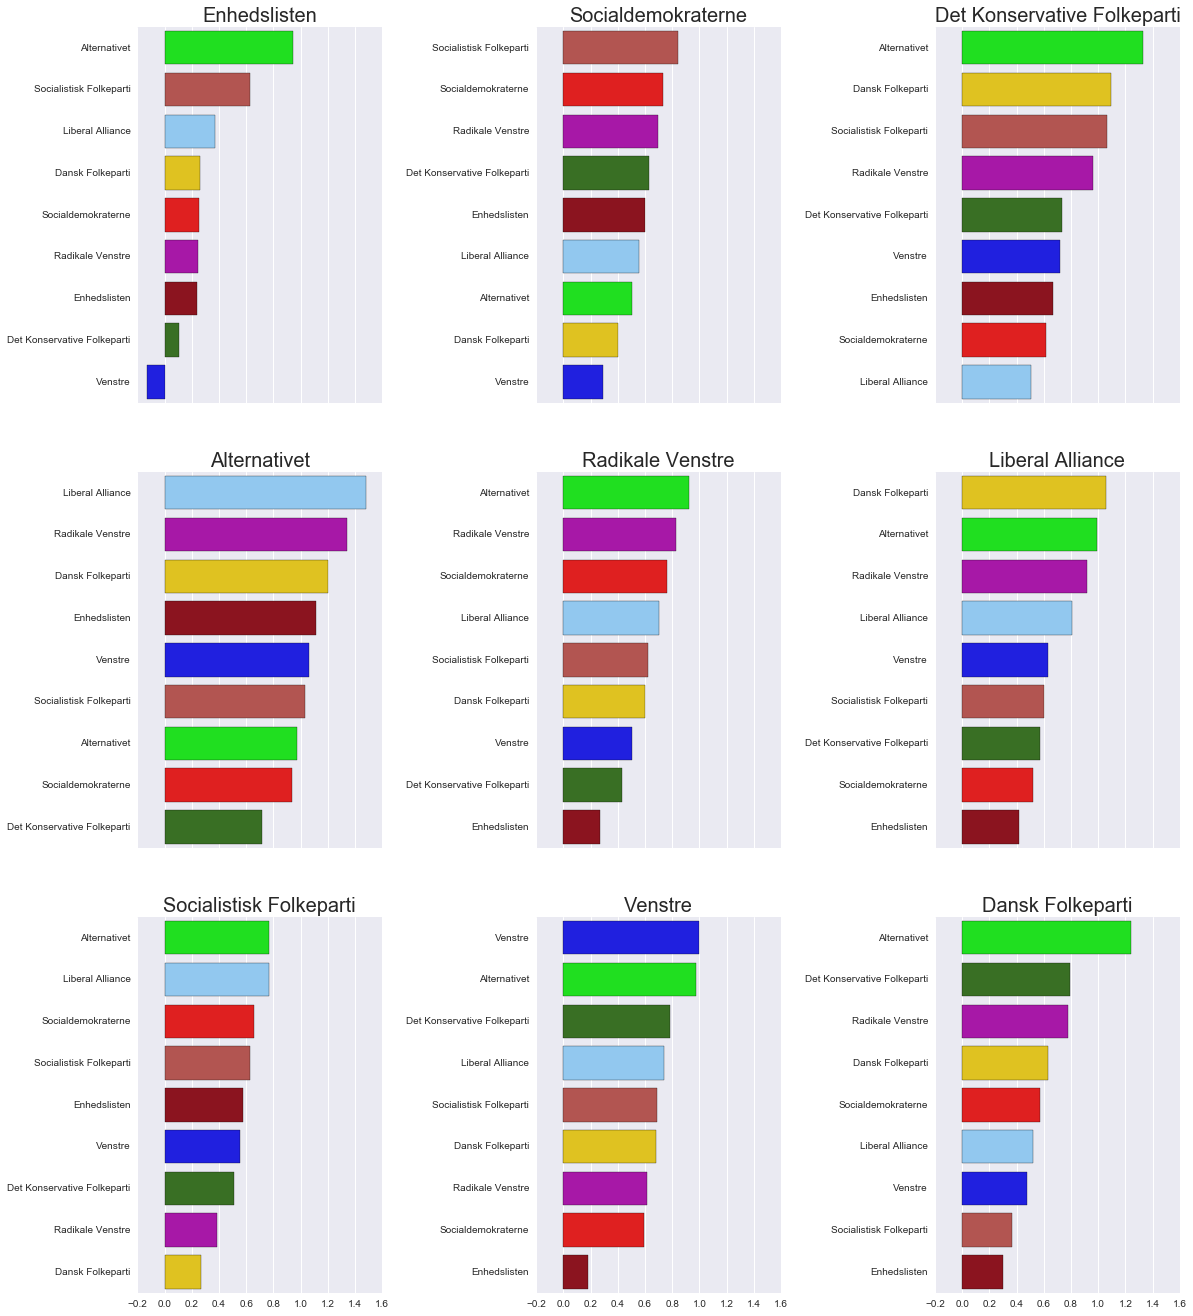

In [46]:
plotPoliticalPartySentiment(partiesReferenceSentiment)

Based upon these plot there seems to be a small tendency for parties to write more positively about parties they share politicial values with.

## Conclusion
As we stated ealier in the report it is quite difficult to point what the reasons are of polticial alienation, and the reasons are problably numerous. Our research seems to indicate that it is not by promoting negative rhetoric about political adversaries on twitter that they are inciting a disbelief in politicians. 

However, our simple sentiment analysis is good when trying to determine wether a text is generally positive or negative, but not good a deciphering complex sentence structure and intricate natural language details. Such as whether a positivite/negativite word is referring to a specific person, or whether a positive word is used sarcasticly.
It is therefore not possible from our analysis whether politicians writing about each other in positive terms on twitter.
But we can determine that politicians generally talk more about their own party members and party members of fellow minded parties, more than they talk about politicians from parties of the other side of the political spectrum.

### Future work
The are other natural language processing tools available, which we would like to try. Such as the google natural language processing API, which can deconstruct a text into sentences with individual sentiment profiles. Giving a more detailed picture of the references.

Poltiticians have become more active on twitter so doing the same data analysis could interesting. 

# Appendices

## Appendix A

In [ ]:
import tweetDictionizer
reload(tweetDictionizer)
ad = AlphabetDetector()

for party in parties:
    # get names of all the politicians that are part of the party
    fileNamesList = fullDf.loc[fullDf['Party'] == party]['twitterAccount']
    fileNamesList = ["cleaned_politikere_tweets/" + fileName[1:] + ".csv" for fileName in fileNamesList]
    wordDict = {}
    

    # feed filenames to MRJob script with filepaths
    mr_job = tweetDictionizer.MRTweetDictionizer(args=fileNamesList)
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            # collect output from MRJob script
            key, value = mr_job.parse_output_line(line)
            if not isinstance(key, unicode):
                key = key.decode('utf-8')
                # key is transformed into unicode 
                # so that it can be checked wether or not it
                # contains letters tha do no not 
                # belong to the western alphabet
            if ad.is_latin(key):
                # remove all ',' '.' fro
                key = key.encode('utf-8').replace(',', '').replace('.', '')
                if not 'http' in key:
                    if key not in wordDict:
                        wordDict[key] = value 
                    else:
                        wordDict[key] += value


    pickle.dump(collections.OrderedDict(sorted(wordDict.iteritems(), 
                                           key=lambda t: t[1], reverse=True)), 
            open("politiciansWordCount/" + party + "WordCount.p", "wb" ) )
    
    print "finished " + party

## Appendix B

In [104]:
def calc_moving(text,moving_size):
    # initialize array with mean 0.
    moving_text = deque([0]*moving_size,maxlen=moving_size) 
    moving_date = deque(maxlen=moving_size)
    values = []
    # iterate through the tuples
    # and append the text and date
    # to two different arrays
    for key,value in text.itertuples():
        moving_text.append(value)
        moving_date.append(key)
        # calculate average of date and value
        values.append((
                np.array(moving_date, dtype='datetime64[D]').view('i8').mean().astype('datetime64[D]'),
                np.average(moving_text)))
    return values

## Appendix C

In [ ]:
#!/bin/bash
FILES=politikere_tweets/*
for f in $FILES
do
  gawk -v RS='"' 'NR % 2 == 0 { gsub(/\n/, "") } { printf("%s%s", $0, RT) }' $f > "cleaned_"$f
done

## Appendix D

In [ ]:
import csv
def csvCleaner(fileName, identifyerWord):
    with open('cleaned_politikere_tweets/' + fileName, 'rb') as inp, open('cleaned_politikere_tweets/' +'new'+fileName, 'wb') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if not identifyerWord in row[2]:
                writer.writerow(row)

## Appendix E

This is how our MRJob script is defined in another file

In [ ]:
# encoding: utf-8
from mrjob.job import MRJob
from mrjob.step import MRStep
from tweetProtocol import TweetProtocol
import re
import fileinput
from glob import glob
import os

class MRSentiment(MRJob):
    sentiment = {}
    fnames = glob('AFINN-*.txt')
    for line in fileinput.FileInput(fnames):
        words = line.split('\t')
        if not isinstance(words[0], unicode):
            word = words[0].decode('utf-8')
        sentiment[word] = words[1]
    
    INPUT_PROTOCOL = TweetProtocol
    def steps(self):
        return [
            MRStep(
                mapper=self.columnMapper
            ),
            MRStep(
                mapper=self.wordMapper,
                reducer=self.wordCount
            )
        ]
    def columnMapper(self, _, columns):
        try: 
            yield columns[1][:10], columns[2]
        except:
            pass

    def wordMapper(self, key, tweet):
        words = tweet.split()
        for word in words:
            if not isinstance(word, unicode):
                word = word.decode('utf-8')
            word = re.sub(r"[,.]", '', word.lower(), flags=re.U)
            if word in self.sentiment:
                yield key, float(self.sentiment[word])

    def wordCount(self, key, values):
        a = []
        for value in values:
            a.append(value)
        yield key, sum(a)/float(len(a))


if __name__ == '__main__':
    MRSentiment.run()

And this is how it was called from a notebook to calculate the sentiment of the parties over time

In [ ]:
import tweetSentimentOverTime
reload(tweetSentimentOverTime)
import os

for party in set(list(fullDf[pd.notnull(fullDf['Party'])]['Party'])):
    partinavn = party
    soap = {}
    fileNamesList = []
    for twitterHandle in list(fullDf[fullDf['Party'] == partinavn]['twitterAccount']):
        fileNamesList.append("cleaned_politikere_tweets/"+twitterHandle[1:]+".csv")

    mr_job = tweetSentimentOverTime.MRSentiment(args=fileNamesList)
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            # collect output from MRJob script
            key, value = mr_job.parse_output_line(line)
            soap[key] = value
    with open ('partier/sentiment_'+partinavn+'.tsv','a') as f:
        for k,v in sorted(soap.iteritems()):
            f.write("{}\t{}\n".format(k, v))